# UCI time series examples

In [2]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import warnings
import os
from random import randint
from scipy.ndimage.filters import uniform_filter1d
from numpy.random import normal
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
#from statsmodels.tsa.arima_model import 

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
os.getcwd()

'/Users/brunobarbarioli/Documents/Research/OTSS'

In [4]:
from algorithms.online_subsampler import *
from algorithms.analytics import *
from algorithms.breakpoint_detection import *
from algorithms.empirical_bernstein import *
from algorithms.uniform_subsampler import *
from algorithms.queries import *
from algorithms.size_optimizer import *

## Example 1 - UCI Household power consumption

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [5]:
path = '/Users/brunobarbarioli/Documents/Research/OTSS/datasets/household_power_consumption.txt'
data = pd.read_csv(path, sep = ';')

In [6]:
print(data.head(5))

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [8]:
data = data[data.Sub_metering_1 != '?']
data = data[data.Sub_metering_2 != '?']
data = data[data.Sub_metering_3 != '?']

In [9]:
data.index = pd.to_datetime(data['Date'] +' '+ data['Time'])
data_clean = data.drop(columns = ['Date', 'Time'])

In [ ]:
data_clean.info()

### Sub metering 3

In [10]:
x = data_clean['Sub_metering_3']
x = x['2007-01':'2008-12']

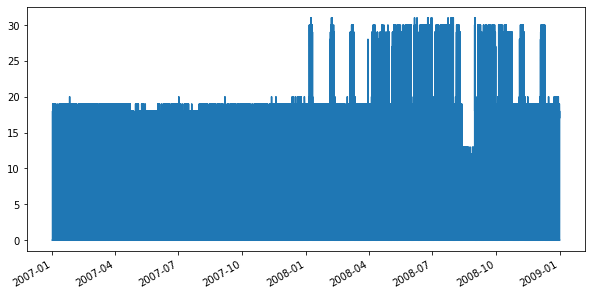

In [11]:
plt.figure(figsize=(10,5))
x.plot()

### Voltage

In [12]:
y = data_clean['Voltage']
y = y.astype('float')
y = y['2007-01':'2008-12']

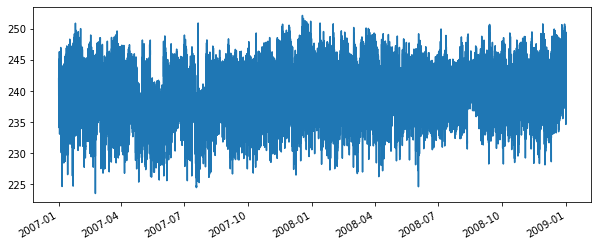

In [13]:
plt.figure(figsize=(10,4))
y.plot()